In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from math import*
from torch.utils.data import DataLoader, Dataset



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
d=500
L=2
r=1

np.random.seed(10)
init1=np.random.randn(d,1).astype(np.float32)
np.random.seed(20)
init2=np.random.randn(d,1).astype(np.float32)


w1=torch.from_numpy(init1)

w2=torch.from_numpy(init2)






In [ ]:
w1.flatten()@w2.flatten()/d

tensor(0.0594)

In [ ]:

def get_y(n):

    x=torch.randn((n,L,d))

    sftm=torch.nn.Softmax(dim=-1)

    xQ=torch.einsum("imk,kl->iml",x,w1)/np.sqrt(d)
    Att1=sftm(torch.einsum("iml,inl->imn",xQ,xQ))
    h1=torch.einsum("imn, ink->imk", Att1, x)+x
    xQ2=torch.einsum("imk,kl->iml",h1,w2)/np.sqrt(d)
    Att2=sftm(torch.einsum("iml,inl->imn",xQ2,xQ2))


    y=Att2
    return x.to(device),y.to(device)



In [ ]:

class generate_data(Dataset):
  def __init__(self,n):
    self.X,self.Y=get_y(n)
    self.samples=n


  def __getitem__(self,idx):
    return self.X[idx].to(device),self.Y[idx].to(device)

  def __len__(self):
    return self.samples


In [ ]:
proj1=torch.eye(w1.shape[0])-(w1@w1.T)/torch.linalg.norm(w1)**2
proj2=torch.eye(w2.shape[0])-(w2@w2.T)/torch.linalg.norm(w2)**2

In [ ]:
init=torch.randn(w1.shape)

In [ ]:
w1.T@proj2@init

tensor([[-2.8434]])

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self, d,r,seed):
        super(Attention, self).__init__()
        self.planting1=0.0
        np.random.seed(seed)
        init1=np.random.randn(d,r).astype(np.float32)
        np.random.seed(seed+20)
        init2=np.random.randn(d,r).astype(np.float32)
        init1=torch.from_numpy(init1)
        init2=torch.from_numpy(init2)

        self.Q1=torch.nn.Parameter(init1*(1-self.planting1)*.9+self.planting1*w1)
        self.Q2=torch.nn.Parameter(init2*(1-self.planting1)*.9+self.planting1*w2)
        print(self.Q1[0])

        self.Att1=None



    def forward(self, x):
        sftm=torch.nn.Softmax(dim=-1)
        xQ=torch.einsum("imk,kl->iml",x,self.Q1)/np.sqrt(d)
        Att1=sftm(torch.einsum("iml,inl->imn",xQ,xQ))
        h1=torch.einsum("imk,ikl->iml",Att1, x)+x
        xQ2=torch.einsum("imk,kl->iml",h1,self.Q2)/np.sqrt(d)
        Att2=sftm(torch.einsum("iml,inl->imn",xQ2,xQ2))


        yhat=Att2
        return yhat

In [ ]:
def quadloss(ypred, y):
    return torch.sum((ypred-y)**2)/d

In [ ]:


def train(train_loader, X_test,y_test,tol=1e-5,verbose=False,tied=False,wd=0.07/d, seed=42, n_passes=3):
    Att=Attention(d,r,seed).to(device)

    optimizer = torch.optim.SGD([{'params': [Att.Q1,Att.Q2],"weight_decay":wd}],lr=15)

    gen_Loss_list=[]
    Loss_list=[]
    Q1_list=[]
    M1_list=[]
    Q2_list=[]
    M2_list=[]


    for t in range(1700):

        if t%500==0: print(t)
        for x,y in train_loader:



          for j in range(n_passes):
            y_pred = Att(x)
            loss = quadloss(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          Loss_list.append(loss.item()+wd/2*float(torch.sum(Att.Q1.cpu().flatten()**2)))
          M1_list.append(float(Att.Q1.cpu().flatten()@w1.flatten()/d))
          Q1_list.append(float(Att.Q1.cpu().flatten()@Att.Q1.cpu().flatten()/d))
          M2_list.append(float(Att.Q2.cpu().flatten()@w2.flatten()/d))
          Q2_list.append(float(Att.Q2.cpu().flatten()@Att.Q2.cpu().flatten()/d))


        if t%20==0 and t>0 :

            gen_Loss_list.append(float(torch.mean((y_test-Att(X_test))**2)))

    Q1=Att.Q1.cpu().flatten()
    Q2=Att.Q2.cpu().flatten()







    m1=Q1@w1.flatten()/d
    q1=Q1@Q1/d
    m2=Q2@w2.flatten()/d
    q2=Q2@Q2/d
    print(q1)

    c1=np.array(M1_list)/np.array(Q1_list)**.5
    c2=np.array(M2_list)/np.array(Q2_list)**.5


    plt.plot(np.abs(c1),  alpha=0.8, label="layer 1")
    plt.plot(np.abs(c2),  alpha=0.3, label="layer 2")
    plt.xlabel("training time"); plt.ylabel("cosine similarity");plt.legend();plt.xscale("log");plt.title(r"$\alpha={}$".format(alpha))#;plt.show()




    return c1, c2

In [ ]:

def get_errors(alpha,N_iter=8):
    global theta
    C1=None
    C2=None
    first=True
    n=int(d*alpha)

    for j in range(N_iter):

        print("############################################",j)
        X_test,y_test=get_y(2000)
        X_train=generate_data(n)
        train_loader=DataLoader(X_train,batch_size=int(int(200)))#put batch size n if one wants to do GD

        cs1, cs2=train(train_loader,X_test,y_test, seed=42)




        if first:
            first=False
            c1=cs1
            c2=cs2

        else:
            c1=np.vstack((c1,cs1))
            c2=np.vstack((c2,cs2))

    return c1,c2

############################################ 0
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1279, grad_fn=<DivBackward0>)
############################################ 1
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1293, grad_fn=<DivBackward0>)
############################################ 2
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1167, grad_fn=<DivBackward0>)
############################################ 3
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1199, grad_fn=<DivBackward0>)
############################################ 4
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1175, grad_fn=<DivBackward0>)
############################################ 5
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1144, grad_fn=<DivBackward0>)
############################################ 6
tensor([0.4470], grad_fn=<SelectBackward0>)
0
500
1000
1500
tensor(0.1289, gr

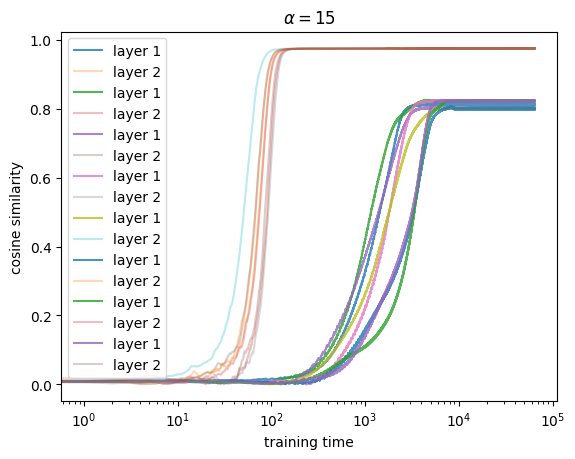

In [ ]:
alpha=15
alphas=[alpha]

C1, C2=get_errors(alpha)

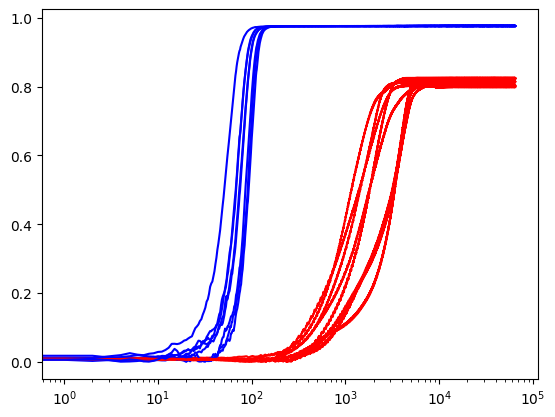

In [ ]:
for seed in range(C1.shape[0]):
  plt.plot(np.abs(C1[seed]), c="red")
  plt.plot(np.abs(C2[seed]), c="blue")


plt.xscale("log")

In [ ]:
np.save("C1_informed0.npy",C1)
np.save("C2_informed0.npy",C2)

In [ ]:

fig, ax = plt.subplots(1,3, figsize=(12,3))
ax=ax.flatten()
ax[0].errorbar(alphas, Eg.mean(1),yerr=Eg.std(1), label=r"$\epsilon_g$")
ax[0].legend()




ax[1].errorbar(alphas, Q.mean(1),yerr=Q.std(1), label=r"$q_1$")




ax[1].legend()


ax[2].errorbar(alphas, Loss.mean(1),yerr=Loss.std(1), label=r"$Loss$")
ax[2].legend()

for axx in ax:
  axx.set_xlabel(r"$\alpha$")



In [ ]:
np.save("alphas.npy", alphas)

In [ ]:
np.save("Eg_inf.npy", Eg)
np.save("Q_inf.npy", alphas)
np.save("Loss_inf.npy", Loss)

In [ ]:


def train(train_loader, X_test,y_test,tol=1e-5,verbose=False,tied=False,wd=0.07/d, seed=42, n_passes=3):
    Att=Attention(d,r,seed).to(device)

    optimizer = torch.optim.SGD([{'params': [Att.Q1,Att.Q2],"weight_decay":wd}],lr=15)

    gen_Loss_list=[]
    Loss_list=[]
    Q1_list=[]
    M1_list=[]
    Q2_list=[]
    M2_list=[]


    for t in range(1700):

        if t%500==0: print(t)
        for x,y in train_loader:



          for j in range(n_passes):
            y_pred = Att(x)
            loss = quadloss(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          Loss_list.append(loss.item()+wd/2*float(torch.sum(Att.Q1.cpu().flatten()**2)))
          M1_list.append(float(Att.Q1.cpu().flatten()@w1.flatten()/d))
          Q1_list.append(float(Att.Q1.cpu().flatten()@Att.Q1.cpu().flatten()/d))
          M2_list.append(float(Att.Q2.cpu().flatten()@w2.flatten()/d))
          Q2_list.append(float(Att.Q2.cpu().flatten()@Att.Q2.cpu().flatten()/d))


        if t%20==0 and t>0 :

            gen_Loss_list.append(float(torch.mean((y_test-Att(X_test))**2)))

    Q1=Att.Q1.cpu().flatten()
    Q2=Att.Q2.cpu().flatten()







    m1=Q1@w1.flatten()/d
    q1=Q1@Q1/d
    m2=Q2@w2.flatten()/d
    q2=Q2@Q2/d
    print(q1)


    plt.plot(np.abs(np.array(M1_list)/np.array(Q1_list)**.5),  alpha=0.8, label="layer 1")
    plt.plot(np.abs(np.array(M2_list)/np.array(Q2_list)**.5),  alpha=0.3, label="layer 2")
    plt.xlabel("training time"); plt.ylabel("cosine similarity");plt.legend();plt.xscale("log");plt.title(r"$\alpha={}$".format(alpha));plt.show()
    plt.plot(Loss_list, c="b", alpha=0.3); plt.show()




    return np.mean(gen_Loss_list[-5:]),m1.detach().numpy(),q1.detach().numpy(),m2.detach().numpy(),q2.detach().numpy(),np.mean(Loss_list[-1:])